In [2]:
#*********TEST *********
import os,sys
import glob
import numpy as np
import random
import shutil 
from PIL import Image
import pandas as pd
import nibabel as nib
import imageio
import matplotlib
import matplotlib.image as mpimg
from nibabel.viewers import OrthoSlicer3D
from pathlib import Path
from matplotlib import pylab as plt
plt.style.use("ggplot")
%matplotlib inline
from skimage.util import img_as_ubyte
import imageio
from sklearn.preprocessing import minmax_scale
from warnings import filterwarnings
import cv2
pd.set_option('display.max_colwidth', None)
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
DataPath = "Full"

dirs = []
images = []
subfolder = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'BraTS19'in filename:
            dirs.append(dirname)
            subfolder.append(filename)
            images.append(filename.replace('.gz', '')) #replace currently not necessary

In [ ]:
imagePath_df = pd.DataFrame({'directory':dirs, 'subfolder': subfolder, 'imagetypes': images})

In [ ]:
imagePath_df

In [ ]:
imgtype = []
for i in imagePath_df["subfolder"]:
    if i[-8:-4] == "t1ce":
        imgtype.append("T1CE")
    elif i[-9:-4] == "flair":
        imgtype.append("FLAIR")
    elif i[-7:-4] == "seg":
        imgtype.append("SEG")
    elif i[-6:-4] == "t2":
        imgtype.append("T2")
    else:
        imgtype.append("T1")
        
imagePath_df["imagetypes"] = imgtype

In [ ]:
imagePath_df.shape

In [ ]:
img_df = imagePath_df.copy()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
img_df['fullpath'] =  img_df['directory']+ '/' + img_df['subfolder']
img_df = img_df.copy()
img_dfT = img_df
img_dfT = img_dfT.copy()
img_dfT.head()

In [ ]:
def read_niifile(niifilepath): #read niifile file
        img = nib.load(niifilepath) #download niifile file (actually extract the file)
        img_fdata = img.get_fdata() #Get niifile data
        return img_fdata


def save_fig(niifilepath,savepath): #Save as picture
    try:
        os.makedirs(savepath)
    except FileExistsError:
        pass
    folderpath = Path(niifilepath)
    folder_parts = folderpath.parts
    ftype = folder_parts[3].split('_')
    ftype = ftype[4].replace('.nii','')
    fdata = read_niifile(niifilepath) #Call the above function to get data
    (x,y,z) = fdata.shape #Get data shape information: (length, width, dimension-number of slices, fourth dimension)   
    for k in range(z):        
        silce = fdata[k,:,:] #Three positions represent three slices with different angles
        shape = silce.shape        
        img = minmax_scale(silce.ravel(), feature_range=(0,255)).reshape(shape)        
        img = img.astype(np.uint8)         #applying range to image as 0 to 255
        imageio.imwrite(os.path.join(savepath, folder_parts[1] + '-'+ 'Sagital'+ '-'+ folder_parts[2] +'_'+ ftype + '_' + 'sliceno' + '-'+'{}.png'.format(k)), img) #Save the slice information as png format
    print("All " + folder_parts[2] + " Sagital Nii file conversion to png complete")
    for k in range(z):        
        silce = fdata[:,k,:] #Three positions represent three slices with different angles
        shape = silce.shape        
        img = minmax_scale(silce.ravel(), feature_range=(0,255)).reshape(shape)        
        img = img.astype(np.uint8)  #applying range to image as 0 to 255
        imageio.imwrite(os.path.join(savepath, folder_parts[1] + '-'+ 'Coronal'+ '-'+ folder_parts[2] +'_'+ ftype + '_' + 'sliceno' + '-'+'{}.png'.format(k)), img) #Save the slice information as png format
    print("All " + folder_parts[2] + " Coronal Nii file conversion to png complete")
    for k in range(z):        
        silce = fdata[:,:,k] #Three positions represent three slices with different angles
        shape = silce.shape        
        img = minmax_scale(silce.ravel(), feature_range=(0,255)).reshape(shape)        
        img = img.astype(np.uint8)   #applying range to image as 0 to 255
        imageio.imwrite(os.path.join(savepath, folder_parts[1] + '-'+ 'Axial'+ '-'+ folder_parts[2] +'_'+ ftype + '_' + 'sliceno' + '-'+'{}.png'.format(k)), img) #Save the slice information as png format
    print("All " + folder_parts[2] + " Axial Nii file conversion to png complete")

In [ ]:
#invoking nii file conversion
#Removed Folders due to byte size BraTS19_CBICA_ABY_1

#invoking nii file conversion
for paths in img_dfT['fullpath']:
    #savepath='/content/drive/My Drive/Colab Notebooks/Brats2019 AI/Images'
    savepath = "C:/Brain Tumor Validation/Images_Final"
    print(paths)
    save_fig(paths,savepath)
print("Images Successfully Copied")

In [ ]:

import os,sys
from PIL import Image
def resizeimg(width, height):
    %cd  "C:/Brain Tumor Validation/Images_final"
    # for each image in the current directory
    #path = '/content/drive/My Drive/Colab Notebooks/Brats2019 AI/Images'
    for image in os.listdir(os.getcwd()):
        # open the image
        img = Image.open(image)        
        img.resize((width,height)).save(image)        
        img.close()
        
#resize image        
resizeimg(256,256)
    

In [ ]:

#rotating images
def rotateImages(rotationAmt):
    %cd  "C:/Brain Tumor Validation/Images_final"
    # for each image in the current directory
    #path = '/content/drive/My Drive/Colab Notebooks/Brats2019 AI/Images'
    for image in os.listdir(os.getcwd()):
        # open the image
        img = Image.open(image)
        # rotate and save the image with the same filename
        img.rotate(rotationAmt).save(image)
        # close the image
        img.close()

#Rotate image by -90 Degrees
rotateImages(90)

In [2]:
import glob
imagesl = glob.glob('C:\Brain Tumor Validation\Images_final\*.png')
df_pr = pd.DataFrame({'Image_dir': imagesl})

In [3]:
df_pr

,Image_dir
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-0.png
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-1.png
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-10.png
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png
...,...
755620,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png
755621,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-96.png
755622,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-97.png
755623,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-98.png


In [4]:
imgtype = []
sub = []
slce = []
for pths in df_pr["Image_dir"]:
    pth = Path(pths)
    pth_prts = pth.parts
    imagefle = pth_prts[3]
    imagetype = imagefle.split('_')
    subdata = "_".join(imagetype[:4])
    slcenum = imagetype[5].replace(".png","")
    imgtype.append(imagetype[4])
    sub.append(subdata)
    slce.append(slcenum)

df_pr["subfolder"]= sub       
df_pr["imagetypes"] = imgtype
df_pr["slicenum"] = slce
df_pr

,Image_dir,subfolder,imagetypes,slicenum
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-0.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-0
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-1.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-1
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-10.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-10
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101
...,...,...,...,...
755620,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-95
755621,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-96.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-96
755622,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-97.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-97
755623,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-98.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-98


In [6]:
df_pr["folder_slice"] = df_pr["subfolder"] + df_pr["slicenum"]
df_pr.head()

,Image_dir,subfolder,imagetypes,slicenum,folder_slice
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-0.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-0,HGG-Axial-BraTS19_2013_17_1sliceno-0
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-1.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-1,HGG-Axial-BraTS19_2013_17_1sliceno-1
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-10.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-10,HGG-Axial-BraTS19_2013_17_1sliceno-10
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101


In [8]:
image = Image.open("C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-0.png")
pix_val = image.getdata()
sum(pix_val)

0

In [9]:
df_pr.columns

Index(['Image_dir', 'subfolder', 'imagetypes', 'slicenum', 'folder_slice'], dtype='object')

In [10]:
df_img = df_pr.loc[df_pr["imagetypes"]!="seg"]
df_seg = df_pr.loc[df_pr["imagetypes"]=="seg"]
df_seg.columns = ['seg_dir', 'subfolder', 'imagetypes', 'slicenum', 'folder_slice'] #renaming img_dir
df_seg = df_seg.drop(["subfolder", "imagetypes", "slicenum"], axis=1) #dropping irrelevant columns

In [11]:
#pair segment with origanal image based on folder and slice number
df = pd.merge(df_img, df_seg, on="folder_slice", how = "left")
df.head()

,Image_dir,subfolder,imagetypes,slicenum,folder_slice,seg_dir
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-0.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-0,HGG-Axial-BraTS19_2013_17_1sliceno-0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-0.png
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-1.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-1,HGG-Axial-BraTS19_2013_17_1sliceno-1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-1.png
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-10.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-10,HGG-Axial-BraTS19_2013_17_1sliceno-10,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-10.png
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png


In [ ]:
#### ***********************************************

In [12]:
#Identify Pixel Size of images

pix = []
for pic in df['Image_dir']:
    img = Image.open(pic)
    pix_val = img.getdata()
    pix.append(sum(pix_val))    

df['img_pixel_count'] = pix
df.head()

,Image_dir,subfolder,imagetypes,slicenum,folder_slice,seg_dir,img_pixel_count
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-0.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-0,HGG-Axial-BraTS19_2013_17_1sliceno-0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-0.png,0
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-1.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-1,HGG-Axial-BraTS19_2013_17_1sliceno-1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-1.png,2957
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-10.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-10,HGG-Axial-BraTS19_2013_17_1sliceno-10,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-10.png,187461
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926


In [13]:
#Identify Pixel Size of segments
pix1 = []
for pic in df['seg_dir']:
    img = Image.open(pic)
    pix_val1 = img.getdata()
    pix1.append(sum(pix_val1))    

df['seg_pixel_count'] = pix1
df.head()

,Image_dir,subfolder,imagetypes,slicenum,folder_slice,seg_dir,img_pixel_count,seg_pixel_count
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-0.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-0,HGG-Axial-BraTS19_2013_17_1sliceno-0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-0.png,0,0
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-1.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-1,HGG-Axial-BraTS19_2013_17_1sliceno-1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-1.png,2957,0
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-10.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-10,HGG-Axial-BraTS19_2013_17_1sliceno-10,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-10.png,187461,0
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968,569052
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926,525452


In [14]:
#find blurry images
sharplst = []
for pics in df["Image_dir"]:
    im = Image.open(pics).convert('L') #to grayscale
    array = np.asarray(im, dtype=np.int32)    
    gy, gx = np.gradient(array)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    sharplst.append(sharpness)
    
df['Image_Contrast'] = sharpness

In [15]:
df

,Image_dir,subfolder,imagetypes,slicenum,folder_slice,seg_dir,img_pixel_count,seg_pixel_count,Image_Contrast
0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-0.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-0,HGG-Axial-BraTS19_2013_17_1sliceno-0,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-0.png,0,0,2.698186
1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-1.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-1,HGG-Axial-BraTS19_2013_17_1sliceno-1,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-1.png,2957,0,2.698186
2,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-10.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-10,HGG-Axial-BraTS19_2013_17_1sliceno-10,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-10.png,187461,0,2.698186
3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968,569052,2.698186
4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926,525452,2.698186
...,...,...,...,...,...,...,...,...,...
604495,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-95,LGG-Sagital-BraTS19_TMC_09043_1sliceno-95,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-95.png,1706414,1185358,2.698186
604496,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-96.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-96,LGG-Sagital-BraTS19_TMC_09043_1sliceno-96,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-96.png,1872545,1124575,2.698186
604497,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-97.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-97,LGG-Sagital-BraTS19_TMC_09043_1sliceno-97,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-97.png,1651053,1055237,2.698186
604498,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-98.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-98,LGG-Sagital-BraTS19_TMC_09043_1sliceno-98,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-98.png,1624300,1026346,2.698186


In [16]:
#df = df1.copy()

In [17]:
pd.set_option('display.max_colwidth', None)
img_pixel = df[["imagetypes", "img_pixel_count"]]
img_pixel.groupby(["imagetypes"]).mean().astype('int64') 

,img_pixel_count
imagetypes,
flair,1158319
t1,1573655
t1ce,958373
t2,985361


In [18]:
pd.set_option('display.max_colwidth', None)
seg_pixel = df[["imagetypes", "seg_pixel_count"]]
seg_pixel.groupby(["imagetypes"]).mean().astype('int64') 

,seg_pixel_count
imagetypes,
flair,122521
t1,122521
t1ce,122521
t2,122521


In [20]:
#removing from df all images with less than  mean pixels for images and segment and mean contrast
df = df.loc[(df["img_pixel_count"] > df["img_pixel_count"].mean()) | (df["seg_pixel_count"] > df["seg_pixel_count"].mean()) | (df["Image_Contrast"] > df["Image_Contrast"].mean())]
df.describe().astype("int64")

,img_pixel_count,seg_pixel_count,Image_Contrast
count,314419,314419,314419
mean,1980836,232680,2
std,742581,269327,0
min,96609,0,2
25%,1432344,0,2
50%,1831029,155167,2
75%,2426574,382271,2
max,5728430,1882216,2


In [21]:
#df.to_csv('brainmri_pixelcount.csv')

In [3]:
df1 = pd.read_csv('brainmri_pixelcount.csv')

In [4]:
df = df1.copy()

In [5]:
print(df.shape, df.columns)

(190959, 13) Index(['Unnamed: 0', 'Image_dir', 'subfolder', 'imagetypes', 'slicenum',
       'folder_slice', 'seg_dir', 'img_pixel_count', 'seg_pixel_count',
       'Tumor_Class', 'destination', 'source_destination', 'Contrast'],
      dtype='object')


In [8]:
#copying images to unique folder
for paths in df['Image_dir']:
    source = paths
    destination = "C:/Brain Tumor Validation/all_images/"
    shutil.copy(source, destination)

In [7]:
#copying segemented images to unique folder
for pics in df['seg_dir']:
    source = pics
    destination = "C:/Brain Tumor Validation/all_images/"
    shutil.copy(source, destination)

In [27]:
df = df1.copy()

In [28]:
#isolating non glioma images
tumor_slice = []
for pic in df['seg_dir']:
    #print(pic)
    img = Image.open(pic)
    p = Path(pic)
    img_parts = p.parts
    gliomatype = img_parts[3].split("-")
    if img.getbbox() == None:
        tumor_slice.append('No_Tumor')
    elif gliomatype[0] == "HGG":
        tumor_slice.append("HGG")
    else:
        tumor_slice.append("LGG")

df["Tumor_Class"] = tumor_slice

In [29]:
df['destination'] = + df['Tumor_Class'] + '/' + df['Image_dir']
df.head(3)

,Unnamed: 0,Image_dir,subfolder,imagetypes,slicenum,folder_slice,seg_dir,img_pixel_count,seg_pixel_count,Tumor_Class,destination,source_destination,Contrast
0,3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968,569052,HGG,HGG/C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png+/C:/processed/HGG/Images_final,2.698186
1,4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926,525452,HGG,HGG/C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png+/C:/processed/HGG/Images_final,2.698186
2,5,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-102,HGG-Axial-BraTS19_2013_17_1sliceno-102,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-102.png,2209039,470359,HGG,HGG/C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png+/C:/processed/HGG/Images_final,2.698186


In [30]:
loc = []
for pic in df['destination']:
    img_pth = Path(pic)
    img_prts = img_pth.parts
    new_path = '/' + img_prts[1] + '/' + 'processed' + '/' + img_prts[0] + '/' + img_prts[3]
    loc.append(new_path)

df['destination'] = loc
df.head()

,Unnamed: 0,Image_dir,subfolder,imagetypes,slicenum,folder_slice,seg_dir,img_pixel_count,seg_pixel_count,Tumor_Class,destination,source_destination,Contrast
0,3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968,569052,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png+/C:/processed/HGG/Images_final,2.698186
1,4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926,525452,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png+/C:/processed/HGG/Images_final,2.698186
2,5,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-102,HGG-Axial-BraTS19_2013_17_1sliceno-102,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-102.png,2209039,470359,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png+/C:/processed/HGG/Images_final,2.698186
3,6,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-103.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-103,HGG-Axial-BraTS19_2013_17_1sliceno-103,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-103.png,2185228,419286,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-103.png+/C:/processed/HGG/Images_final,2.698186
4,7,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-104.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-104,HGG-Axial-BraTS19_2013_17_1sliceno-104,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-104.png,2131042,394959,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-104.png+/C:/processed/HGG/Images_final,2.698186


In [31]:
df['source_destination'] = df['Image_dir'] + '+' + df['destination']
df

,Unnamed: 0,Image_dir,subfolder,imagetypes,slicenum,folder_slice,seg_dir,img_pixel_count,seg_pixel_count,Tumor_Class,destination,source_destination,Contrast
0,3,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-100,HGG-Axial-BraTS19_2013_17_1sliceno-100,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-100.png,2283968,569052,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-100.png+/C:/processed/HGG/Images_final,2.698186
1,4,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-101,HGG-Axial-BraTS19_2013_17_1sliceno-101,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-101.png,2228926,525452,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-101.png+/C:/processed/HGG/Images_final,2.698186
2,5,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-102,HGG-Axial-BraTS19_2013_17_1sliceno-102,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-102.png,2209039,470359,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-102.png+/C:/processed/HGG/Images_final,2.698186
3,6,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-103.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-103,HGG-Axial-BraTS19_2013_17_1sliceno-103,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-103.png,2185228,419286,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-103.png+/C:/processed/HGG/Images_final,2.698186
4,7,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-104.png,HGG-Axial-BraTS19_2013_17_1,flair,sliceno-104,HGG-Axial-BraTS19_2013_17_1sliceno-104,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_seg_sliceno-104.png,2131042,394959,HGG,/C:/processed/HGG/Images_final,C:\Brain Tumor Validation\Images_final\HGG-Axial-BraTS19_2013_17_1_flair_sliceno-104.png+/C:/processed/HGG/Images_final,2.698186
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190954,604495,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-95,LGG-Sagital-BraTS19_TMC_09043_1sliceno-95,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-95.png,1706414,1185358,LGG,/C:/processed/LGG/Images_final,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png+/C:/processed/LGG/Images_final,2.698186
190955,604496,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-96.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-96,LGG-Sagital-BraTS19_TMC_09043_1sliceno-96,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-96.png,1872545,1124575,LGG,/C:/processed/LGG/Images_final,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-96.png+/C:/processed/LGG/Images_final,2.698186
190956,604497,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-97.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-97,LGG-Sagital-BraTS19_TMC_09043_1sliceno-97,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_seg_sliceno-97.png,1651053,1055237,LGG,/C:/processed/LGG/Images_final,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-97.png+/C:/processed/LGG/Images_final,2.698186
190957,604498,C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-98.png,LGG-Sagital-BraTS19_TMC_09043_1,t2,sliceno-98,LGG-Sagital-BraTS19_TMC_09043_1slic

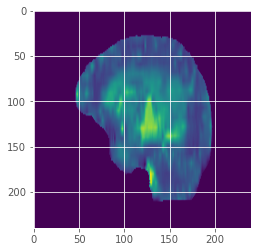

In [32]:
img = mpimg.imread('C:\Brain Tumor Validation\Images_final\LGG-Sagital-BraTS19_TMC_09043_1_t2_sliceno-95.png')
plt.imshow(img)
plt.show()

In [33]:
df_nt = df.loc[df["Tumor_Class"] == "No_Tumor"]
df_hgg = df.loc[df["Tumor_Class"] == "HGG"]
df_lgg = df.loc[df["Tumor_Class"] == "LGG"]
print(df_nt.shape[0], df_hgg.shape[0], df_lgg.shape[0])

41231 110447 39281


In [34]:
df_train = df.sample(frac = 0.85)
df_test = df[~df.isin(df_train)].dropna()
df_train.shape, df_test.shape

((162315, 13), (28644, 13))

In [35]:
df_train1 = df_train.sample(frac = 0.25)
df_test1 = df_test.sample(frac = 0.25)

In [36]:
#creating Training folder
processed = "C:/Brain Tumor Validation/Training/"
try:
    os.mkdir(processed)
except FileExistsError:
    pass


#seperate glioma slices into respective folders
#src = "/content/Images/"

lgg2 = "C:/Brain Tumor Validation/Training1/LGG/"

hgg2 = "C:/Brain Tumor Validation/Training1/HGG/"

NT = "C:/Brain Tumor Validation/Training1/NO_TUMOR/"

for paths in df_train['source_destination']:
    src_dest = paths.split("+")
    src1 = src_dest[0]
    dest = src_dest[1]
    glioma_tp = Path(dest)
    glioma_tp = glioma_tp.parts
    tumor_type = glioma_tp[3]
    if tumor_type == "HGG":
        try:
            os.mkdir(hgg2)
        except FileExistsError:
            pass
        shutil.copy(src1, hgg2)
    elif tumor_type == "No_Tumor":
        try:
            os.mkdir(NT)
        except FileExistsError:
            pass
        shutil.copy(src1, NT)
    else:
        try:
            os.mkdir(lgg2)
        except FileExistsError:
            pass
        shutil.copy(src1, lgg2)

In [37]:
lgg12 = glob.glob('C:/Brain Tumor Validation/Training1/LGG/*.png')
df_lgg12 = pd.DataFrame({'Image_dir': lgg12})

In [38]:
hgg12 = glob.glob('C:/Brain Tumor Validation/Training1/HGG/*.png')
df_hgg12 = pd.DataFrame({'Image_dir': hgg12})

In [39]:
nt12 = glob.glob('C:/Brain Tumor Validation/Training1/NO_TUMOR/*.png')
df_nt12 = pd.DataFrame({'Image_dir': nt12})

In [40]:
print("Training LGG: ", df_lgg12.shape[0])
print("Training No Tumor: ", df_nt12.shape[0])
print("Training HGG :", df_hgg12.shape[0])

Training LGG:  33436
Training No Tumor:  34963
Training HGG : 93916


In [41]:
#creating Testing folder
processed = "C:/Brain Tumor Validation/Testing/"
try:
    os.mkdir(processed)
except FileExistsError:
    pass


#seperate glioma slices into respective folders
#src = "/content/Images/"

lgg2 = "C:/Brain Tumor Validation/Testing1/LGG/"

hgg2 = "C:/Brain Tumor Validation/Testing1/HGG/"

NT = "C:/Brain Tumor Validation/Testing1/NO_TUMOR/"

for paths in df_test['source_destination']:
    src_dest = paths.split("+")
    src1 = src_dest[0]
    dest = src_dest[1]
    glioma_tp = Path(dest)
    glioma_tp = glioma_tp.parts
    tumor_type = glioma_tp[3]
    if tumor_type == "HGG":
        try:
            os.mkdir(hgg2)
        except FileExistsError:
            pass
        shutil.copy(src1, hgg2)
    elif tumor_type == "No_Tumor":
        try:
            os.mkdir(NT)
        except FileExistsError:
            pass
        shutil.copy(src1, NT)
    else:
        try:
            os.mkdir(lgg2)
        except FileExistsError:
            pass
        shutil.copy(src1, lgg2)

In [42]:
nt11 = glob.glob('C:/Brain Tumor Validation/Testing1/NO_TUMOR/*.png')
df_nt11 = pd.DataFrame({'Image_dir': nt11})

In [43]:
lgg11 = glob.glob('C:/Brain Tumor Validation/Testing1/LGG/*.png')
df_lgg11 = pd.DataFrame({'Image_dir': lgg11})

In [44]:
hgg11 = glob.glob('C:/Brain Tumor Validation/Testing1/HGG/*.png')
df_hgg11 = pd.DataFrame({'Image_dir': hgg11})

In [45]:
print("Training LGG: ", df_lgg11.shape[0])
print("Training No Tumor: ", df_nt11.shape[0])
print("Training HGG :", df_hgg11.shape[0])

Training LGG:  5845
Training No Tumor:  6268
Training HGG : 16531


In [ ]:
#df.to_csv('brainmri_pixelcount.csv')